In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold

import os
if not os.path.isdir('figures'):
    os.makedirs('figures')
if not os.path.isdir('no_early'):
    os.makedirs('no_early')

In [2]:
# scaler for data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [3]:
def plot_loss_and_save(history, beta, fold):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('beta %s, fold %s model loss'%(beta,fold))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','validate'], loc= 'upper right' )
    plt.ylim(0,1)
    plt.savefig('./figures/4A_beta_%s_fold_%s_loss.png'%(beta,fold))
    plt.show()

In [4]:
def plot_acc_and_save(history, beta, fold):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('beta %s, fold % accuracy'%(beta,fold))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validate'], loc= 'lower right' )
    plt.ylim(0,1)
    plt.savefig('./figures/4A_beta_%s_fold_%s_accuracy.png'%(beta,fold))
    plt.show()

In [5]:
NUM_CLASSES = 3

epochs = 1500
batch_size = 8
num_neurons = 10
seed = 10

num_attributes = 21
num_folds = 5

weight_decay=[0,1e-3,1e-6,1e-9,1e-12]

np.random.seed(seed)
tf.random.set_seed(seed)

histories={}
performances={}

In [6]:
dataset = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
X, Y = dataset[1:,:21], dataset[1:,-1].astype(int)
Y = Y - 1 #For python that start from 0

#Split to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = seed, shuffle=True)

#Scale based on training set 
X_test = scale(X_test,np.min(X_train,axis = 0),np.max(X_train, axis=0))
X_train = scale(X_train, np.min(X_train, axis = 0),np.max(X_train, axis = 0 ))

In [7]:
#Define K fold
kfold = KFold(n_splits=num_folds,shuffle=True,random_state = seed)

#Define model constructor
def build_model(beta_decay):
    #Model definition
    model = keras.Sequential()
    model.add(keras.layers.Dense(num_neurons, activation = 'relu',input_dim = num_attributes,kernel_regularizer=keras.regularizers.l2(beta_decay)))
    model.add(keras.layers.Dense(NUM_CLASSES, activation ='softmax'))

    #default of sgd is lr = 0.01 so no need specify
    model.compile(optimizer='sgd',
                 loss = keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
    return model

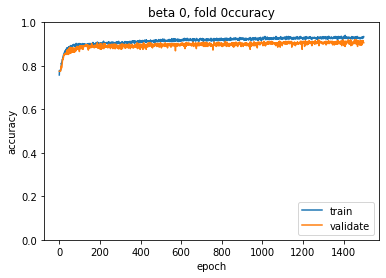

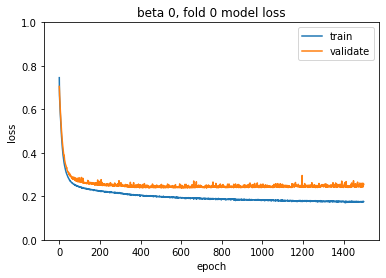

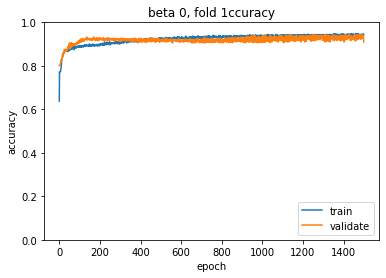

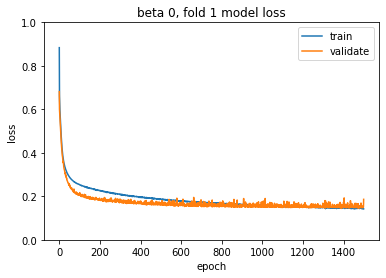

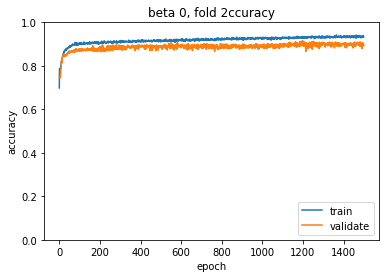

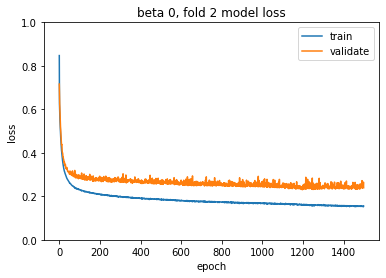

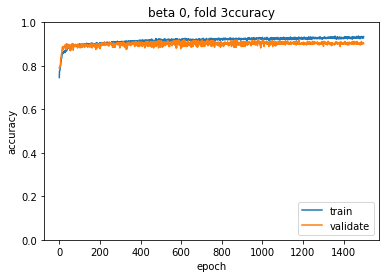

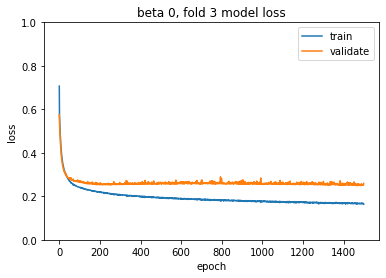

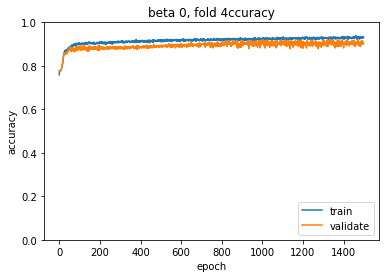

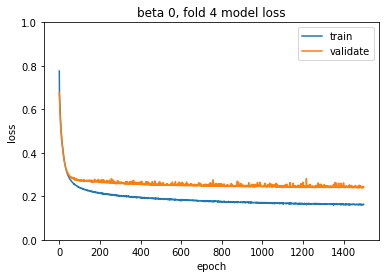

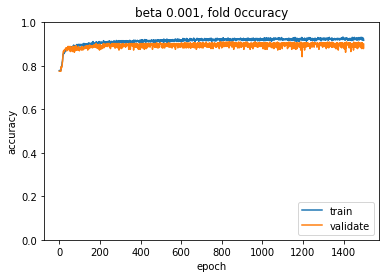

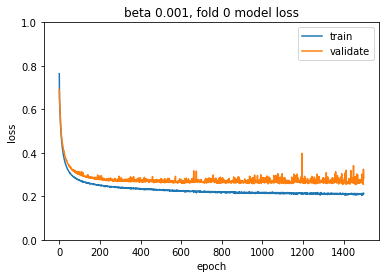

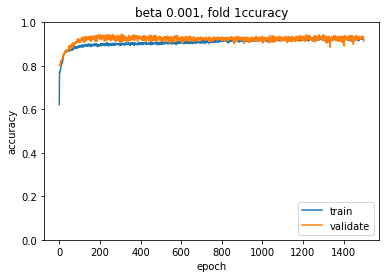

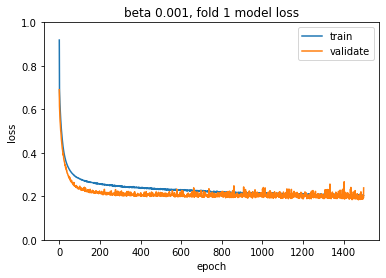

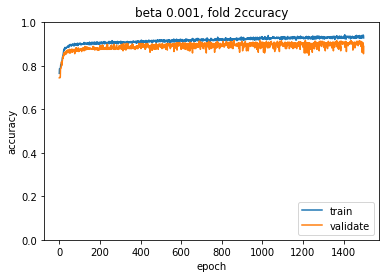

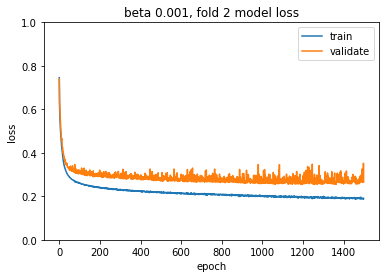

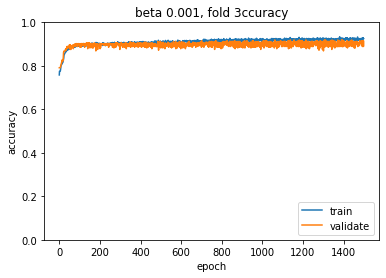

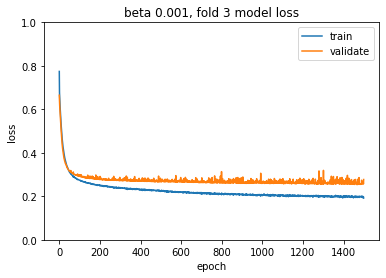

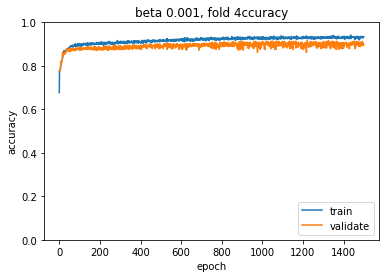

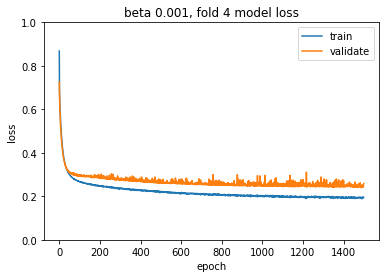

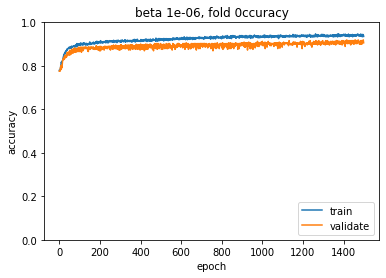

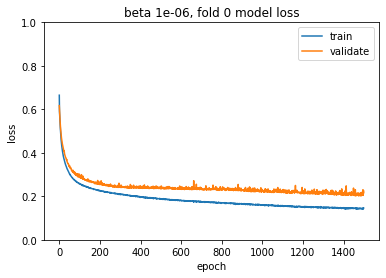

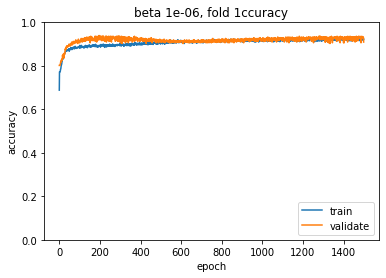

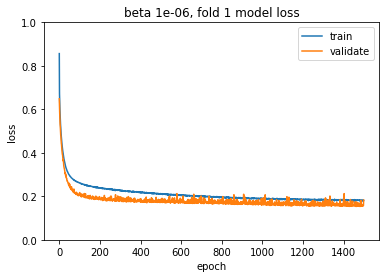

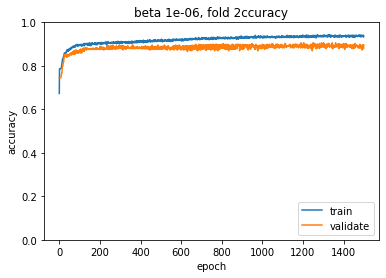

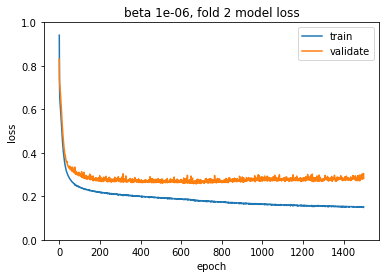

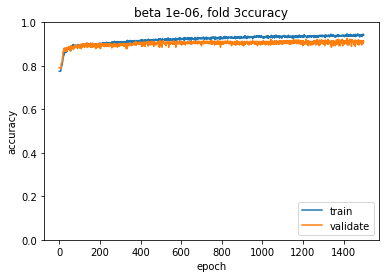

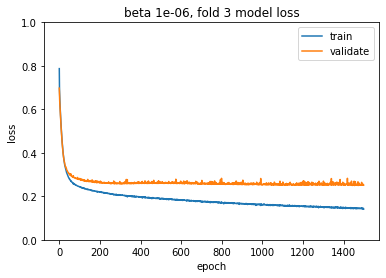

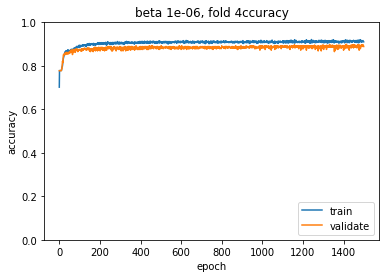

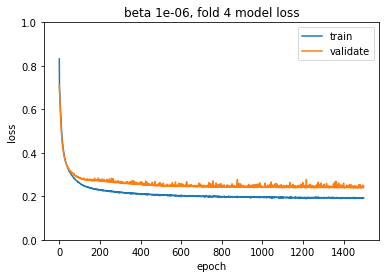

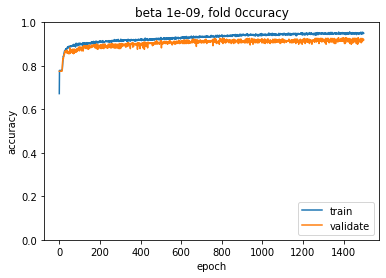

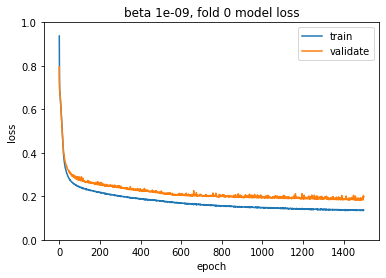

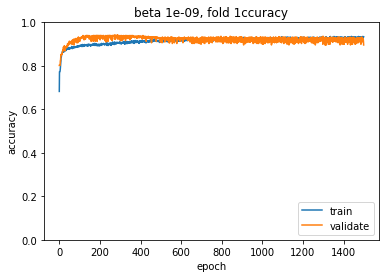

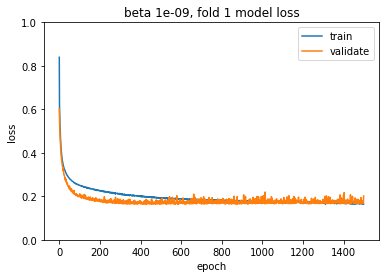

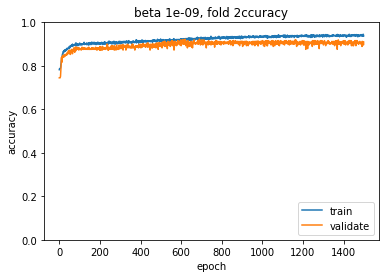

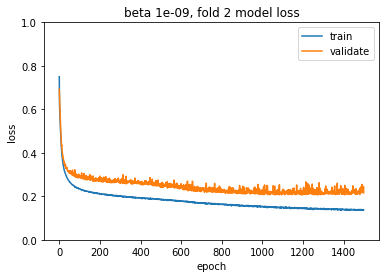

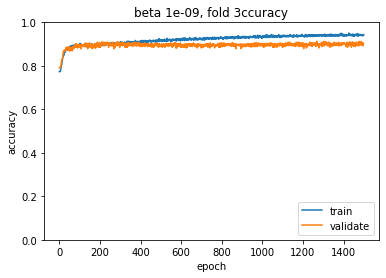

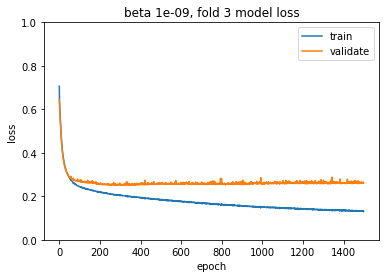

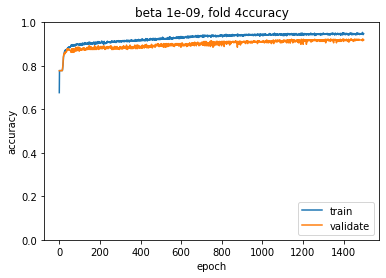

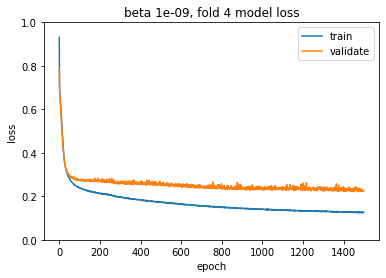

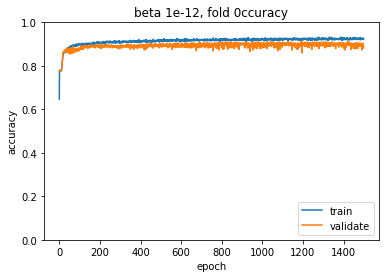

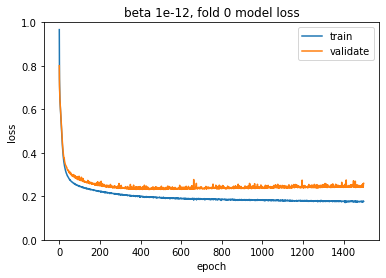

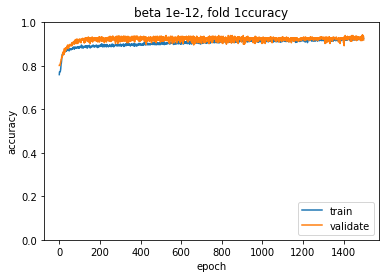

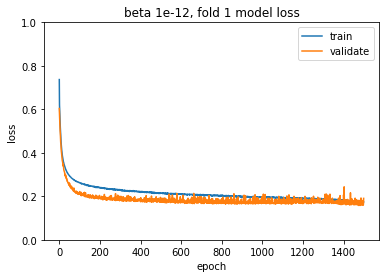

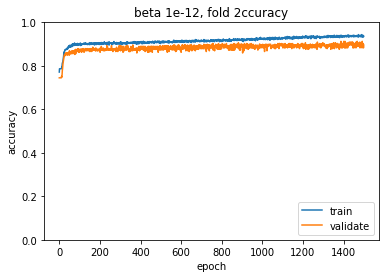

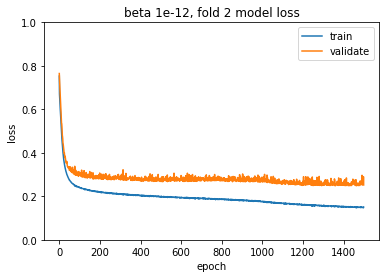

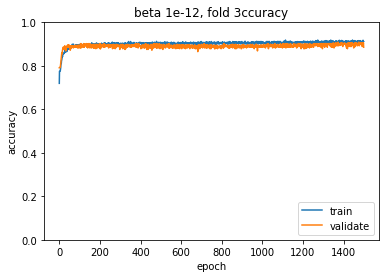

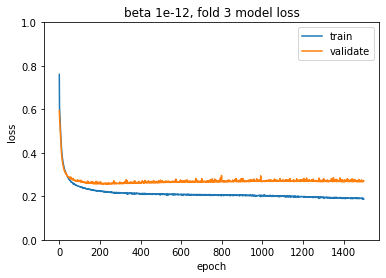

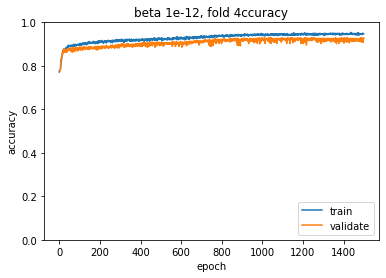

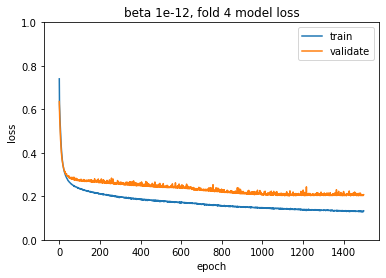

In [8]:
for beta in weight_decay:
    fold = 0
    beta_histories = {}
    model_accuracies = []
    
    for train_idx, test_idx in kfold.split(X_train,Y_train):
        fold_csv_logger = keras.callbacks.CSVLogger('./no_early/4A_fold_%s_beta_%s.csv' % (fold,beta))
        callbacks = [fold_csv_logger]
        #Build model and fit for training
        model = build_model(beta)
        beta_histories['fold_%s'%fold] = model.fit(X_train[train_idx],Y_train[train_idx],
                                                   validation_data = (X_train[test_idx],Y_train[test_idx]),
                                                   epochs = epochs,
                                                   verbose = 0,
                                                   batch_size=batch_size,
                                                   callbacks=callbacks)
        
        plot_acc_and_save(beta_histories['fold_%s'%fold],beta,fold)
        plot_loss_and_save(beta_histories['fold_%s'%fold],beta,fold)
        
        fold += 1 #Update fold number
                                                    
    #Update history of this beta into main history
    histories['beta_%s_histories'%beta]=beta_histories